# "Goin' for the stat trick" or "Stats gonna leave a mark"

### A cross-checking of historical hockey data to predict future success using machine learning and neural networks.
<center><img src="images/foil_up.jpeg"><center>

##### Team Members: Dave Kingsley, Erin Lampa, Ricky Ravin, Justin Miller & Katie Wright

In [1]:
# Dependencies 

%matplotlib inline
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import glob
import seaborn as sns
from sklearn.svm import SVC
from sklearn import svm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Data pre-processing steps for all data sets:

1. We imported and merged 10 years worth of data for teams, skaters and skaters advanced statistics.  2013 was excluded from the data set due to the lockout and subsequent partial season.

2. Columns containing text ("Team", "Player", "Position", "Average Time On Ice") were removed for modeling.  These columns weren't necessary for the models as the goal was to estimate points and extrapolate team/skater from those numbers.

3. Checked for null values and if found inserted the mean of that column into that cell to allow for applying standard scalar and fit transformation.

4. Used .describe() to determine the min and max of the points column which was then used to assign appropriate bins for the data.



In [2]:
# Read the csv file into a pandas DataFrame

season = pd.concat([pd.read_csv(f) for f in glob.glob('nhl_season_data/*.csv')], 
                             ignore_index = True)

season.head(10)

,Rk,Team,AvAge,GP,W,L,OL,PTS,PTS%,GF,...,PK%,SH,SHA,PIM/G,oPIM/G,S,S%,SA,SV%,SO
0,1,San Jose Sharks*,28.7,82,53,18,11,117,0.713,251,...,83.22,12,11,12.8,14.1,2720,9.2,2228,0.911,9
1,2,Boston Bruins*,28.4,82,53,19,10,116,0.707,270,...,82.35,8,7,12.5,12.8,2482,10.9,2524,0.925,7
2,3,Detroit Red Wings*,31.2,82,51,21,10,112,0.683,289,...,78.29,6,4,10.0,10.9,2965,9.7,2274,0.894,8
3,4,Washington Capitals*,27.2,82,50,24,8,108,0.659,268,...,80.62,7,11,12.7,11.4,2747,9.8,2418,0.901,2
4,5,New Jersey Devils*,30.3,82,51,27,4,106,0.646,238,...,79.94,12,4,12.9,13.1,2698,8.8,2415,0.914,7
5,6,Chicago Blackhawks*,25.9,82,46,24,12,104,0.634,260,...,80.61,10,6,14.1,15.2,2683,9.7,2344,0.911,6
6,7,Vancouver Canucks*,27.9,82,45,27,10,100,0.610,243,...,81.40,7,5,16.5,16.3,2335,10.4,2392,0.911,10
7,8,Pittsburgh Penguins*,26.6,82,45,28,9,99,0.604,258,...,82.71,7,13,13.6,14.2,2381,10.8,2484,0.906,4
8,9,Philadelphia Flyers*,27.0,82,44,27,11,99,0.604,260,...,82.95,16,1,17.5,14.8,2441,10.7,2668,0.913,3
9,10,Calgary Flames*,28.9,82,46,30,6,98,0.598,251,...,83.38,6,15,15.8,15.6,2643,9.5,2441,0.899,4


In [3]:
# Drop Team column

season_clean = season.drop(columns='Team')

In [4]:
# Determine if any columns have null values that need to be removed
# also helps determine column names

season_clean.isnull().sum()

Rk        0
AvAge     0
GP        0
W         0
L         0
OL        0
PTS       0
PTS%      0
GF        0
GA        0
SOW       0
SOL       0
SRS       0
SOS       0
TG/G      0
EVGF      0
EVGA      0
PP        0
PPO       0
PP%       0
PPA       0
PPOA      0
PK%       0
SH        0
SHA       0
PIM/G     0
oPIM/G    0
S         0
S%        0
SA        0
SV%       0
SO        0
dtype: int64

In [5]:
# Determine max of points column to determine appropriate bins

season_clean['PTS'].describe()

count    301.000000
mean      91.667774
std       13.689263
min       48.000000
25%       82.000000
50%       93.000000
75%      101.000000
max      128.000000
Name: PTS, dtype: float64

## Team modeling ....

#### Bins were created to separate the data into teams that were playoff bound and those were not.  Based on the assumption that teams with ~95 points will go to the playoffs (based on information from cbssports.com). .unique() is used to verify the bin value (0) assigned to no_playoffs is less than the value (1) assigned to playoffs before modeling.

In [6]:
# Preprocessing the data: creating appropriate bins to separate out the PTS column into
# "good/playoff" qualifying points and "bad/non-playoff" points.

bins = (47, 94.5, 128)
group_names = ['no_playoffs', 'playoffs']
season_clean['PTS'] = pd.cut(season['PTS'], bins = bins, labels = group_names)
season_clean['PTS'].unique()

[playoffs, no_playoffs]
Categories (2, object): [no_playoffs < playoffs]

In [7]:
# Use LabelEncoder to assign new values to the PTS column

label_quality = LabelEncoder()

In [8]:
# Fit_transform the PTS column using newly encoded values

season_clean['PTS'] = label_quality.fit_transform(season_clean['PTS'])

In [9]:
# Dataframe displaying the newly transformed PTS column

season_clean.head(10)

,Rk,AvAge,GP,W,L,OL,PTS,PTS%,GF,GA,...,PK%,SH,SHA,PIM/G,oPIM/G,S,S%,SA,SV%,SO
0,1,28.7,82,53,18,11,1,0.713,251,199,...,83.22,12,11,12.8,14.1,2720,9.2,2228,0.911,9
1,2,28.4,82,53,19,10,1,0.707,270,190,...,82.35,8,7,12.5,12.8,2482,10.9,2524,0.925,7
2,3,31.2,82,51,21,10,1,0.683,289,240,...,78.29,6,4,10.0,10.9,2965,9.7,2274,0.894,8
3,4,27.2,82,50,24,8,1,0.659,268,240,...,80.62,7,11,12.7,11.4,2747,9.8,2418,0.901,2
4,5,30.3,82,51,27,4,1,0.646,238,207,...,79.94,12,4,12.9,13.1,2698,8.8,2415,0.914,7
5,6,25.9,82,46,24,12,1,0.634,260,209,...,80.61,10,6,14.1,15.2,2683,9.7,2344,0.911,6
6,7,27.9,82,45,27,10,1,0.610,243,213,...,81.40,7,5,16.5,16.3,2335,10.4,2392,0.911,10
7,8,26.6,82,45,28,9,1,0.604,258,233,...,82.71,7,13,13.6,14.2,2381,10.8,2484,0.906,4
8,9,27.0,82,44,27,11,1,0.604,260,232,...,82.95,16,1,17.5,14.8,2441,10.7,2668,0.913,3
9,10,28.9,82,46,30,6,1,0.598,251,246,...,83.38,6,15,15.8,15.6,2643,9.5,2441,0.899,4


In [10]:
# Count the values in each points category (non-playoff and playoff)

season_clean['PTS'].value_counts()

0    164
1    137
Name: PTS, dtype: int64

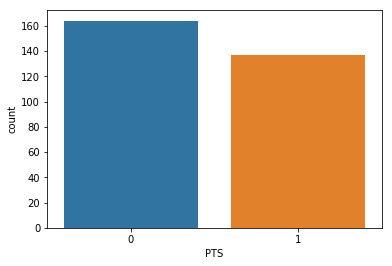

In [11]:
# Visualize the transformed points column distribution 
# using seaborn & matplotlib

sns.countplot(season_clean['PTS'])


In [12]:
# Assign the data to X and y, x predicts y

X = season_clean.drop('PTS', axis = 1)
y = season_clean["PTS"]


In [13]:
# Use train_test_split to create training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [14]:
# Applying standard scaling to get optimized result and reduce large discrepancies
# between the data in each column.

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [15]:
# Visualize the scaled data created for X_train

X_train[:10]

array([[-1.17308356e+00,  3.74733692e-01,  0.00000000e+00,
         1.07373504e+00, -9.29119312e-01, -5.59633071e-01,
         1.01886507e+00,  1.42551373e+00, -8.36716338e-01,
        -8.28020971e-01, -1.25502917e+00,  1.40100143e+00,
        -1.94995056e+00,  4.81924576e-01,  2.11564730e+00,
        -7.33334007e-02, -4.44115167e-01, -1.39556293e+00,
         8.53475784e-01, -1.34882964e+00, -1.48717177e+00,
         5.23566145e-01, -5.84267204e-01, -1.22311229e+00,
        -1.18418205e+00, -1.19261328e+00,  3.24645235e-01,
         1.52691512e+00, -6.15440645e-02,  9.03994816e-01,
        -1.11223333e-01],
       [-2.71124576e-01, -1.14895569e+00,  0.00000000e+00,
         8.01575280e-01, -5.08820028e-02, -2.01053362e+00,
         4.53140717e-01,  1.15000687e+00,  1.77543827e-01,
        -1.25212927e+00, -1.69575848e+00,  6.87548142e-01,
        -2.02129021e-01,  1.03771378e+00,  2.26255106e+00,
         1.44056629e+00, -1.57617343e+00, -1.46857445e+00,
        -1.07769525e+00, -1.96

# Random Forest

#### A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [16]:
# Create Random Forest model

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)

In [17]:
# Display the pred_rfc array

pred_rfc[:20]

array([0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1])

In [18]:
# See how well the model performed

print(classification_report(y_test, pred_rfc))
print(confusion_matrix(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        51
           1       1.00      0.95      0.97        40

   micro avg       0.98      0.98      0.98        91
   macro avg       0.98      0.97      0.98        91
weighted avg       0.98      0.98      0.98        91

[[51  0]
 [ 2 38]]


#### A confusion matrix is a table used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. The relative terminology can be confusing but generally it is used to visualize the number of true negatives (51 in our model), false positives (0 in our model), false negatives (2 in our model), and true positives (38 in our model).  So, the random forest model is slightly better at predicting true negatives than true positives but is highly accurate.

In [19]:
# Random Forest Accuracy Score

from sklearn.metrics import accuracy_score
cm = accuracy_score(y_test, pred_rfc)
cm

0.978021978021978

## SVM (Support Vector Machine) Classifier

#### A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples.

#### SVM works better on smaller numbers, random forest does better with binned numbers, SVM is fastest and easiest to apply with mass data.  The difference between the two will eventually go away with mulitple runs.

In [20]:
# Create SVM model

clf=svm.SVC()
clf.fit(X_train, y_train)
pred_clf = clf.predict(X_test)

In [21]:
# See how well the model performed

print(classification_report(y_test, pred_clf))
print(confusion_matrix(y_test, pred_clf))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        51
           1       0.97      0.93      0.95        40

   micro avg       0.96      0.96      0.96        91
   macro avg       0.96      0.95      0.96        91
weighted avg       0.96      0.96      0.96        91

[[50  1]
 [ 3 37]]


In [22]:
# SVM Accuracy Score

svm = accuracy_score(y_test, pred_clf)
svm

0.9560439560439561

## Neural Network

#### Multi-layer Perceptron (MLP) is a supervised learning algorithm that learns a function  by training on a dataset. Given a set of features and a target, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers.

In [23]:
# Use MLPClassifier to create neural network model

mlpc = MLPClassifier(hidden_layer_sizes=(11,11,11), max_iter=500)
mlpc.fit(X_train, y_train)
pred_mlpc = mlpc.predict(X_test)

In [24]:
# See how well the model performed

print(classification_report(y_test, pred_mlpc))
print(confusion_matrix(y_test, pred_mlpc))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        51
           1       0.97      0.97      0.97        40

   micro avg       0.98      0.98      0.98        91
   macro avg       0.98      0.98      0.98        91
weighted avg       0.98      0.98      0.98        91

[[50  1]
 [ 1 39]]


In [25]:
# Neural Network Accuracy Score

nn = accuracy_score(y_test, pred_mlpc)
nn

0.978021978021978

## Linear Regression Model

#### Linear Regression is a machine learning algorithm based on supervised learning. It performs a regression task. Regression models a target prediction value based on independent variables. It is mostly used for finding out the relationship between variables and forecasting.

In [26]:
# Read the csv file into a pandas DataFrame

season = pd.concat([pd.read_csv(f) for f in glob.glob('nhl_season_data/*.csv')], 
                             ignore_index = True)

season.head(10)

,Rk,Team,AvAge,GP,W,L,OL,PTS,PTS%,GF,...,PK%,SH,SHA,PIM/G,oPIM/G,S,S%,SA,SV%,SO
0,1,San Jose Sharks*,28.7,82,53,18,11,117,0.713,251,...,83.22,12,11,12.8,14.1,2720,9.2,2228,0.911,9
1,2,Boston Bruins*,28.4,82,53,19,10,116,0.707,270,...,82.35,8,7,12.5,12.8,2482,10.9,2524,0.925,7
2,3,Detroit Red Wings*,31.2,82,51,21,10,112,0.683,289,...,78.29,6,4,10.0,10.9,2965,9.7,2274,0.894,8
3,4,Washington Capitals*,27.2,82,50,24,8,108,0.659,268,...,80.62,7,11,12.7,11.4,2747,9.8,2418,0.901,2
4,5,New Jersey Devils*,30.3,82,51,27,4,106,0.646,238,...,79.94,12,4,12.9,13.1,2698,8.8,2415,0.914,7
5,6,Chicago Blackhawks*,25.9,82,46,24,12,104,0.634,260,...,80.61,10,6,14.1,15.2,2683,9.7,2344,0.911,6
6,7,Vancouver Canucks*,27.9,82,45,27,10,100,0.610,243,...,81.40,7,5,16.5,16.3,2335,10.4,2392,0.911,10
7,8,Pittsburgh Penguins*,26.6,82,45,28,9,99,0.604,258,...,82.71,7,13,13.6,14.2,2381,10.8,2484,0.906,4
8,9,Philadelphia Flyers*,27.0,82,44,27,11,99,0.604,260,...,82.95,16,1,17.5,14.8,2441,10.7,2668,0.913,3
9,10,Calgary Flames*,28.9,82,46,30,6,98,0.598,251,...,83.38,6,15,15.8,15.6,2643,9.5,2441,0.899,4


In [27]:
# Drop Team column

season_clean = season.drop(columns='Team')

In [28]:
# Assign the data to X and y, x predicts y

X = season_clean.drop('PTS', axis = 1)
y = season_clean['PTS']

In [29]:
# Use train_test_split to create training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
# Applying standard scaling to get optimized result

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [31]:
# Create the model using LinearRegression

model = LinearRegression()

In [32]:
# Fit the model to the training data and calculate the scores for the training and testing data

model.fit(X_train, y_train)
pred_lrm = model.predict(X_test)

In [33]:
# Determining the features that effect the model the most

model.coef_

array([-3.54235883e-15, -1.77635684e-15,  1.09690035e-13,  6.85129129e+00,
       -7.29422748e+00, -1.86579620e-01,  1.65071775e-13,  2.91729861e-14,
        1.01972352e-13, -3.65656371e-15,  4.21026775e-15,  4.22266433e-14,
       -2.26555886e-15, -8.41973042e-14,  5.20032896e-15, -9.17648224e-15,
       -3.17354302e-16,  1.81799020e-15,  1.11022302e-15, -4.77395901e-15,
       -2.98372438e-16, -7.77156117e-16, -5.55111512e-16, -2.55351296e-15,
        8.74300632e-16, -7.62410968e-16,  1.22124533e-15,  2.22044605e-16,
        1.99840144e-15, -2.99760217e-15, -1.66533454e-15])

#### Indices 3, 4, and 5 have the strongest impact on the model.  These indices correspond to wins, losses and overtime losses respectively.

In [34]:
# Print Training and Test scores

training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 1.0
Testing Score: 1.0


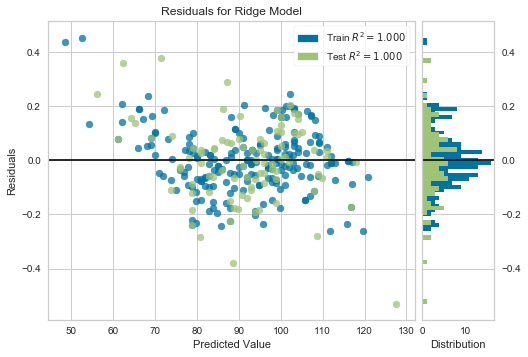

In [35]:
 # Plot the Residuals for Ridge Model
    
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
# Ridge helps prevent over-fitting

ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()                 

In [36]:
# Print mean squared error and R2

from sklearn.metrics import mean_squared_error

predictions = model.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 2.1082524412060448e-29, R2: 1.0


In [37]:
# Predict the 2016 Wild Score

X_wild = [[17,28,82,38,33,11,0.53,213,204,3,2,0.13,0.01,5.09,158,153,48,259,18.53,45,
           204,77.94,7,6,6.6,8.6,2374,9,2347,0.913,8]]
X_wild = sc.transform(X_wild)
y_wild = model.predict(X_wild)
y_wild

array([87.])

## Linear Regression Using Goals For & Against

In [38]:
# Assign the data to X and y, x predicts y

X = season_clean[['GF', 'GA']]
y = season_clean['PTS']

In [39]:
# Use train_test_split to create training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
# Applying standard scaling to get optimized result

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [41]:
# Create the model using LinearRegression

model = LinearRegression()

In [42]:
# Fit the model to the training data and calculate the scores for the training and testing data

model.fit(X_train, y_train)
pred_lrm = model.predict(X_test)

In [43]:
# Determining the features that effect the model the most

model.coef_

array([ 8.69894109, -8.74905836])

In [44]:
# Print Training and Test scores

training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.9113553075585127
Testing Score: 0.8967884572159035


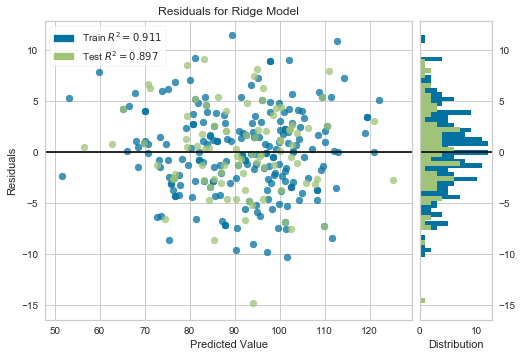

In [45]:
 # Plot the Residuals for Ridge Model
    
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
# Ridge helps prevent over-fitting

ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()  

In [46]:
# Print mean squared error and R2

from sklearn.metrics import mean_squared_error

predictions = model.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 17.60780693883132, R2: 0.8967884572159035


In [47]:
# Predict the 2016 Wild Score

X_wild = [[213,204]]
X_wild = sc.transform(X_wild)
y_wild = model.predict(X_wild)
y_wild

array([95.07405085])

## Linear Regression Using W, L, OL

In [48]:
# Assign the data to X and y, x predicts y

X = season_clean[['W', 'L', 'OL']]
y = season_clean['PTS']

In [49]:
# Use train_test_split to create training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
# Applying standard scaling to get optimized result

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [51]:
# Create the model using LinearRegression

model = LinearRegression()

In [52]:
# Fit the model to the training data and calculate the scores for the training and testing data

model.fit(X_train, y_train)
pred_lrm = model.predict(X_test)

In [53]:
# Determining the features that effect the model the most

model.coef_

array([ 6.85129129, -7.29422748, -0.18657962])

In [54]:
# Print Training and Test scores

training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 1.0
Testing Score: 1.0


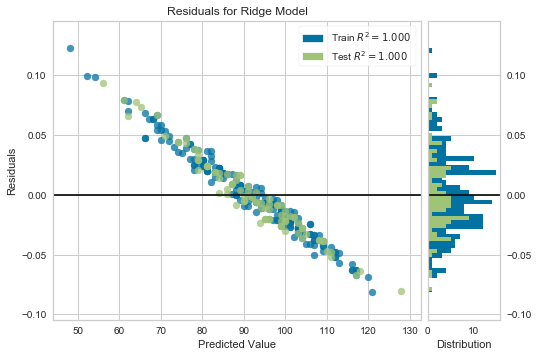

In [55]:
 # Plot the Residuals for Ridge Model
    
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
# Ridge helps prevent over-fitting

ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()  

In [56]:
# Print mean squared error and R2

from sklearn.metrics import mean_squared_error

predictions = model.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 7.878206490822588e-29, R2: 1.0


In [57]:
# Predict the 2016 Wild Score

X_wild = [[38,33,11]]
X_wild = sc.transform(X_wild)
y_wild = model.predict(X_wild)
y_wild

array([87.])

# Linear Regression Using SOS, PPA, PPOA, and SV%

### Here we use only Strength of schedule, Power Play Goals Against and Power Play Opportunities Against to test how accurate the linear regression model is.

In [58]:
# View the dataframe columns to determine features

list(season_clean)

['Rk',
 'AvAge',
 'GP',
 'W',
 'L',
 'OL',
 'PTS',
 'PTS%',
 'GF',
 'GA',
 'SOW',
 'SOL',
 'SRS',
 'SOS',
 'TG/G',
 'EVGF',
 'EVGA',
 'PP',
 'PPO',
 'PP%',
 'PPA',
 'PPOA',
 'PK%',
 'SH',
 'SHA',
 'PIM/G',
 'oPIM/G',
 'S',
 'S%',
 'SA',
 'SV%',
 'SO']

In [59]:
# Assign the data to X and y, x predicts y
# SRS: Simple Rating System, PPA: Power Play Goals Against, PPOA: Power Play, SV%: Save Percentage

X = season_clean[['SOS', 'PPA', 'PPOA', 'SV%']]
y = season_clean['PTS']

In [60]:
# Use train_test_split to create training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [61]:
# Applying standard scaling to get optimized result

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [62]:
# Create the model using LinearRegression

model = LinearRegression()


In [63]:
# Fit the model to the training data and calculate the scores for the training and testing data

model.fit(X_train, y_train)
pred_lrm = model.predict(X_test)

In [64]:
# Determining the features that effect the model the most.

model.coef_

array([-4.57680511, -3.84771811,  2.11631574,  3.73821381])

In [65]:
# Print Training and Test scores

training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.38645601162667576
Testing Score: 0.4540841242646563


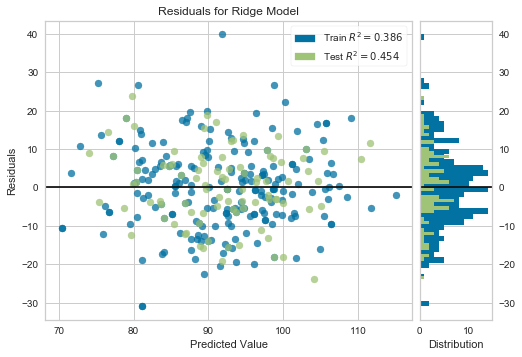

In [66]:
 # Plot the Residuals for Ridge Model
    
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
# Ridge helps prevent over-fitting

ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof() 

In [67]:
# Print values for mean squared error and R2

from sklearn.metrics import mean_squared_error

predictions = model.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 93.13281330266193, R2: 0.4540841242646563


In [68]:
# Predict the 2016 Wild Score (Actual is 87)

X_wild = [[0.01, 45, 204, 0.913]]
X_wild = sc.transform(X_wild)
y_wild = model.predict(X_wild)
y_wild

array([91.16075534])

In [69]:
# Predict the 2016 Ducks Score (Actual is 103)

X_new = [[-0.05, 37, 290, 0.917]]
X_new = sc.transform(X_new)
y_ducks = model.predict(X_new)
y_ducks

array([106.67180968])

In [70]:
# Predict the 2016 Blue Jackets Score (Actual is 76)

X_new = [[0.03, 53, 279, 0.903]]
X_new = sc.transform(X_new)
y_bluejackets = model.predict(X_new)
y_bluejackets

array([85.38060146])

# Predictive Model Comparison using Actual LR Model

In [71]:
# Read in 2016 NHL season csv

season_2006 = pd.read_csv('test_data/2006_team.csv')

season_2006_clean = season_2006[['SOS', 'PPA', 'PPOA', 'SV%']]
season_2006_clean.head()

,SOS,PPA,PPOA,SV%
0,0.05,63,408,0.905
1,-0.16,72,386,0.906
2,0.05,55,390,0.919
3,0.06,61,410,0.912
4,0.08,59,377,0.908


In [72]:
# Predict 2006 NHL Season Points

X = season_2006_clean
y = season_2006['PTS']

for index, row in X.iterrows():
    X_pred = sc.transform(X)
    y_pred = model.predict(X_pred)
    y_pred
    
print(y_pred)


[ 86.87921999 107.21657822  94.92029543  89.61692227  84.62589553
  87.11938333 116.164248   108.50704936  86.89487386 114.42453199
  89.42442874 105.54241863  76.20824504  68.70602448 111.59047399
  94.3912375  107.51845581  85.56409376 101.13416303 104.8926123
 102.37907098  64.55571544  85.31963414  65.07772686  65.31727737
  66.14752962  95.23882576  54.28620098  53.4864812   89.96728603]


In [73]:
# Create a dataframe that shows predicted scores, actual scores and the difference between
# predicted and actual.

team_comparison = pd.DataFrame({'Predicted Scores':y_pred, 'Actual Scores':y})
team_comparison
team_comparison['Score Difference'] = y_pred - y
team_comparison.head()

,Predicted Scores,Actual Scores,Score Difference
0,86.879220,113,-26.120780
1,107.216578,113,-5.783422
2,94.920295,110,-15.079705
3,89.616922,110,-20.383078
4,84.625896,107,-22.374104


In [74]:
# Display .describe() features for creating regplot

team_comparison['Score Difference'].describe()

count    30.000000
mean     -2.596103
std      16.432024
min     -26.293976
25%     -16.103140
50%      -5.559314
75%       9.398308
max      33.967286
Name: Score Difference, dtype: float64

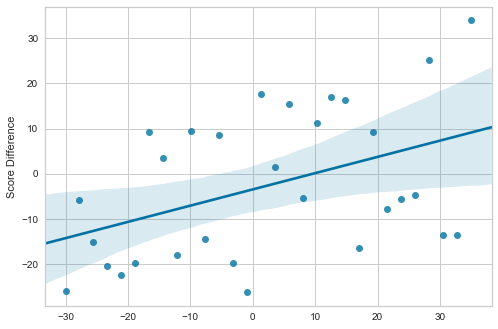

In [75]:
# Use seaborn to plot the linear regression analysis.
# Shaded area corresponds to 95% CI.

x = np.linspace(-30, 35, 30)
y = team_comparison['Score Difference']

sns.regplot(x,y)

# Now, a look at the general skater statistics ...

### Repeat of the steps taken for team statistics

# Read the csv file into a pandas DataFrame

player = pd.concat([pd.read_csv(f) for f in glob.glob('player_data/*.csv')], 
                             ignore_index = True)

player.head()

In [77]:
# Drop columns with text values not needed for modeling

cleandf = player.drop(columns = ['Player', 'Tm', 'Pos', 'ATOI'])
cleandf.head()

,Age,GP,G,A,PTS,+/-,PIM,PS,EV,PP,...,GW,EV.1,PP.1,SH.1,S,TOI,BLK,HIT,FOW,FOL
0,28,1,0,0,0,0,0,0.0,0,0,...,0,0,0,0,1,9,0.0,0,0.0,0.0
1,29,64,7,14,21,-20,50,0.7,2,5,...,1,11,2,1,104,1066,27.0,144,5.0,12.0
2,23,15,1,1,2,-2,4,-0.1,1,0,...,0,1,0,0,12,185,2.0,9,1.0,0.0
3,25,29,2,3,5,3,16,0.5,2,0,...,0,3,0,0,24,301,5.0,80,11.0,18.0
4,24,7,1,2,3,0,2,0.3,1,0,...,0,1,1,0,17,89,3.0,9,0.0,0.0


In [78]:
# Determine max of points column to determine appropriate bins

cleandf['PTS'].describe()

count    8845.000000
mean       20.672018
std        20.800314
min         0.000000
25%         3.000000
50%        14.000000
75%        33.000000
max       113.000000
Name: PTS, dtype: float64

In [79]:
# Replace NAN values with the mean

cleandf.fillna(cleandf.mean(), inplace=True)

In [80]:
# Preprocessing the data

bins = (-1, 33.5, 113)
group_names = ['not_scorer', 'scorer']
cleandf['PTS'] = pd.cut(cleandf['PTS'], bins = bins, labels = group_names)
cleandf['PTS'].unique()

[not_scorer, scorer]
Categories (2, object): [not_scorer < scorer]

In [81]:
# Use LabelEncoder to assign new values to the PTS column

label_quality = LabelEncoder()

In [82]:
# Fit_transform the PTS column using newly encoded values

cleandf['PTS'] = label_quality.fit_transform(cleandf['PTS'])

In [83]:
# Dataframe displaying the newly transformed PTS column

cleandf.head()

,Age,GP,G,A,PTS,+/-,PIM,PS,EV,PP,...,GW,EV.1,PP.1,SH.1,S,TOI,BLK,HIT,FOW,FOL
0,28,1,0,0,0,0,0,0.0,0,0,...,0,0,0,0,1,9,0.0,0,0.0,0.0
1,29,64,7,14,0,-20,50,0.7,2,5,...,1,11,2,1,104,1066,27.0,144,5.0,12.0
2,23,15,1,1,0,-2,4,-0.1,1,0,...,0,1,0,0,12,185,2.0,9,1.0,0.0
3,25,29,2,3,0,3,16,0.5,2,0,...,0,3,0,0,24,301,5.0,80,11.0,18.0
4,24,7,1,2,0,0,2,0.3,1,0,...,0,1,1,0,17,89,3.0,9,0.0,0.0


In [84]:
# Count the values in each points category (not_scorer and scorer)

cleandf['PTS'].value_counts()

0    6684
1    2161
Name: PTS, dtype: int64

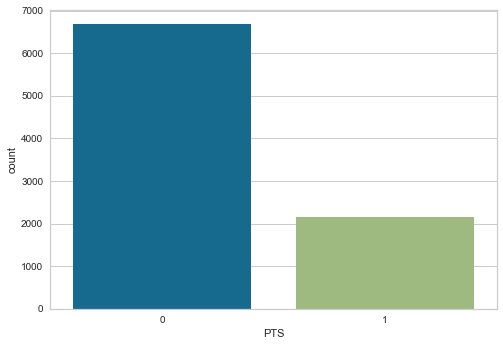

In [85]:
# Visualize the transformed points column distribution 
# using seaborn & matplotlib

sns.countplot(cleandf['PTS'])

In [86]:
# Assign the data to X and y, x predicts y

X = cleandf.drop('PTS', axis = 1)
y = cleandf["PTS"]

In [87]:
# Use train_test_split to create training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [88]:
# Applying standard scaling to get optimized result and reduce large discrepancies
# between the data in each column.

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [89]:
# Visualize the scaled data created for X_train

X_train[:10]

array([[-0.33930397,  0.95918946,  0.48722302, -0.00722265, -1.22472857,
        -0.79078133, -0.30217167,  0.69394534,  0.06180581, -0.35157369,
        -0.69237602,  0.29789816, -0.44398827, -0.41282775,  0.40498043,
         0.53279534,  0.0468289 ,  0.60038186, -0.33336311, -0.34046877],
       [ 1.40776401,  0.16413815, -0.29823878, -0.8423155 , -0.38057481,
         1.76944418, -0.78944449, -0.09909479, -0.5928388 , -0.35157369,
        -0.12791725, -0.86101066, -0.62735928, -0.41282775, -0.40744706,
        -0.63233887, -0.48037988,  0.85034581, -0.39859391, -0.45567106],
       [-1.21283795,  0.78635222,  0.59943185,  0.06869488,  0.25254051,
        -0.59876442,  0.01107515,  1.01116139, -0.26551649, -0.35157369,
         0.43654153,  0.29789816, -0.26061727, -0.41282775,  0.66660962,
         0.13815311, -0.55227199, -0.5601651 , -0.38228621, -0.40959015],
       [-0.33930397,  0.47524518, -0.52265643, -0.53864537, -0.59161325,
         2.28148928, -0.33697687, -0.41631084, -

# Random Forest

In [90]:
# Create Random Forest model

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)

In [91]:
# Display the pred_rfc array

pred_rfc[:20]

array([1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0])

In [92]:
# See how well the model performed

print(classification_report(y_test, pred_rfc))
print(confusion_matrix(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2002
           1       1.00      0.99      0.99       652

   micro avg       1.00      1.00      1.00      2654
   macro avg       1.00      1.00      1.00      2654
weighted avg       1.00      1.00      1.00      2654

[[1999    3]
 [   4  648]]


In [93]:
# Random Forest Accuracy Score

from sklearn.metrics import accuracy_score
cm = accuracy_score(y_test, pred_rfc)
cm

0.9973624717407686

## SVM (Support Vector Machine) Classifier

In [94]:
from sklearn.svm import SVC
from sklearn import svm

# Create SVM model

clf=svm.SVC()
clf.fit(X_train, y_train)
pred_clf = clf.predict(X_test)

In [95]:
# See how well the model performed

print(classification_report(y_test, pred_clf))
print(confusion_matrix(y_test, pred_clf))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2002
           1       0.98      0.98      0.98       652

   micro avg       0.99      0.99      0.99      2654
   macro avg       0.99      0.99      0.99      2654
weighted avg       0.99      0.99      0.99      2654

[[1990   12]
 [  10  642]]


In [96]:
# SVM Accuracy Score

svm = accuracy_score(y_test, pred_clf)
svm

0.9917106254709872

## Neural Network

In [97]:
# Use MLPClassifier to create neural network model

mlpc = MLPClassifier(hidden_layer_sizes=(11,11,11), max_iter=500)
mlpc.fit(X_train, y_train)
pred_mlpc = mlpc.predict(X_test)

In [98]:
# See how well the model performed

print(classification_report(y_test, pred_mlpc))
print(confusion_matrix(y_test, pred_mlpc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2002
           1       1.00      0.99      0.99       652

   micro avg       1.00      1.00      1.00      2654
   macro avg       1.00      0.99      1.00      2654
weighted avg       1.00      1.00      1.00      2654

[[2000    2]
 [   7  645]]


In [99]:
# Neural Network Accuracy Score

nn = accuracy_score(y_test, pred_mlpc)
nn

0.9966088922381311

## Linear Regression

In [100]:
# Prepare data for regression

lineardf = player.drop(columns = ['Player', 'Tm', 'Pos', 'ATOI'])
finaldf = lineardf.dropna()
finaldf.head()

,Age,GP,G,A,PTS,+/-,PIM,PS,EV,PP,...,GW,EV.1,PP.1,SH.1,S,TOI,BLK,HIT,FOW,FOL
0,28,1,0,0,0,0,0,0.0,0,0,...,0,0,0,0,1,9,0.0,0,0.0,0.0
1,29,64,7,14,21,-20,50,0.7,2,5,...,1,11,2,1,104,1066,27.0,144,5.0,12.0
2,23,15,1,1,2,-2,4,-0.1,1,0,...,0,1,0,0,12,185,2.0,9,1.0,0.0
3,25,29,2,3,5,3,16,0.5,2,0,...,0,3,0,0,24,301,5.0,80,11.0,18.0
4,24,7,1,2,3,0,2,0.3,1,0,...,0,1,1,0,17,89,3.0,9,0.0,0.0


In [101]:
# Assign the data to X and y, x predicts y, used model.coef_ to determine the best features

X = finaldf[['EV', 'PP', 'SH']]
y = finaldf['PTS']

In [102]:
# Use train_test_split to create training and testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [103]:
# Applying standard scaling to get optimized result

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [104]:
# Fit the model to the training data and calculate the scores for the training and testing data

model = LinearRegression()

model.fit(X_train, y_train)
pred_lrm = model.predict(X_test)
X.head()

,EV,PP,SH
0,0,0,0
1,2,5,0
2,1,0,0
3,2,0,0
4,1,0,0


In [105]:
# Display model coefficients for each of the features used in
# the linear regression model.

model.coef_

array([11.95853108,  8.36615616,  1.0870526 ])

In [106]:
# Display training and test scores for linear regression model.

training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.8419166892082613
Testing Score: 0.8463431537704258


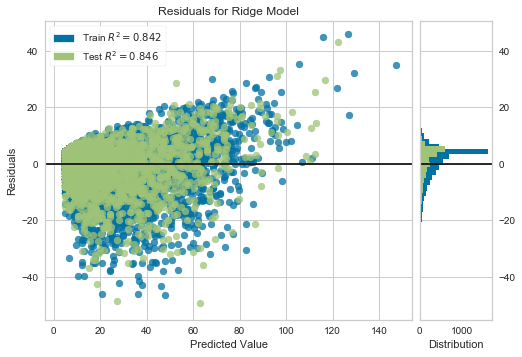

In [107]:
 # Plot the Residuals for Ridge Model
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()  

In [108]:
# Diplay mean squared error and R2 value for linear regression model.

from sklearn.metrics import mean_squared_error

predictions = model.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 66.45458528308693, R2: 0.8463431537704258


# Predictive Model Comparison with Actual Model

In [109]:
# Read in 2006 data only to test our model

df = pd.read_csv('test_data/2006_player.csv')
df.head(5)
cleandf = df[['EV', 'PP', 'SH']]
cleandf.head(5)

,EV,PP,SH
0,1,0,0
1,6,0,1
2,2,0,1
3,1,0,1
4,1,0,0


In [110]:
# Loop through each row in the 2016 data and predict points for each
# Create a dataframe which includes the predicted points, actual points and
# the difference between predicted and actual point.

X = cleandf
y = df['PTS']

for index, row in X.iterrows():
    X_predict = sc.transform(X)
    y_predict = model.predict(X_predict)
    y_predict
    
comparison = pd.DataFrame({'Predicted Scores':y_predict, 'Actual Scores':y})
# comparison.head(5)
comparison['Score Difference'] = y_predict - y


In [111]:
# View .describe() data to create cutoffs for regplot

comparison['Score Difference'].describe()

count    1029.000000
mean        0.260727
std         8.487039
min       -58.904176
25%        -2.656848
50%         2.563160
75%         4.718606
max        25.329473
Name: Score Difference, dtype: float64

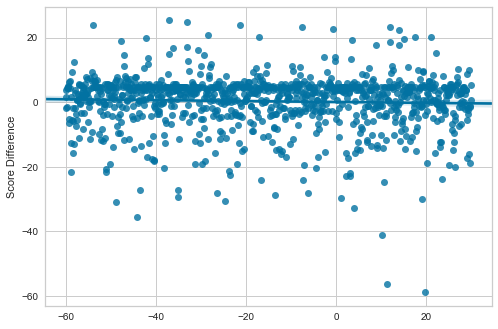

In [112]:
# Plot the point differences on a regression scatter plot that shows linear regression line
# and 95% confidence interval for the regression line

x = np.linspace(-60, 30, 1029)
y = comparison['Score Difference']

sns.regplot(x,y)
plt.show()

# Linear Regression on Advanced Skater Statistics

In [113]:
# Read the csv file into a pandas DataFrame

player = pd.concat([pd.read_csv(f) for f in glob.glob('player_data/*c.csv')], 
                             ignore_index = True)

player.head()

,Player,Age,Tm,Pos,GP,G,A,PTS,+/-,PIM,...,EV.1,PP.1,SH.1,S,TOI,ATOI,BLK,HIT,FOW,FOL
0,Spencer Abbott\abbotsp01,28,CHI,LW,1,0,0,0,0,0,...,0,0,0,1,9,8:34,0.0,0,0.0,0.0
1,Justin Abdelkader\abdelju01,29,DET,LW,64,7,14,21,-20,50,...,11,2,1,104,1066,16:40,27.0,144,5.0,12.0
2,Pontus Aberg\abergpo01,23,NSH,LW,15,1,1,2,-2,4,...,1,0,0,12,185,12:20,2.0,9,1.0,0.0
3,Noel Acciari\acciano01,25,BOS,C,29,2,3,5,3,16,...,3,0,0,24,301,10:22,5.0,80,11.0,18.0
4,Kenny Agostino\agostke01,24,STL,LW,7,1,2,3,0,2,...,1,1,0,17,89,12:47,3.0,9,0.0,0.0


In [114]:
# Read the csv files for advanced data into a pandas DataFrame

advanced = pd.concat([pd.read_csv(f, encoding="ISO-8859-1") for f in glob.glob('advanced_data/*corsi.csv')], 
                             ignore_index = True)

advanced.head()

,Age,CA,CF,CF%,CF% rel,E+/-,FA,FF,FF%,FF% rel,...,SAtt.,TK,TOI(EV),TOI/60,Thru%,Tm,dZS%,oZS%,oiSH%,oiSV%
0,23,628,765,54.9,-0.4,NaN,478,599,55.6,0.7,...,226.0,17,10:26,12:18,57.1,DET,41.2,58.8,8.3,93.6
1,20,201,153,43.2,-6.0,NaN,156,118,43.1,-8.0,...,50.0,2,9:37,11:13,62.0,BUF,46.4,53.6,4.5,92.6
2,33,647,565,46.6,-7.8,NaN,460,424,48.0,-6.0,...,138.0,24,9:05,12:11,65.2,PIT,50.6,49.4,5.6,91.1
3,29,532,470,46.9,-7.3,NaN,377,322,46.1,-8.0,...,53.0,7,13:20,15:08,39.6,VAN,59.4,40.6,9.3,92.1
4,38,702,655,48.3,-2.5,NaN,541,484,47.2,-2.9,...,187.0,45,14:11,19:17,51.3,OTT,47.2,52.8,8.2,88.1


In [115]:
# Merge the player and advanced dataframes together on player and age.

merged_df = pd.merge(player,
                 advanced,
                 on=['Player', 'Age'], 
                 #how='outer', 
                 indicator=True
                )
merged_df.head()

,Player,Age,Tm_x,Pos_x,GP_x,G,A,PTS,+/-,PIM,...,TK,TOI(EV),TOI/60,Thru%,Tm_y,dZS%,oZS%,oiSH%,oiSV%,_merge
0,Spencer Abbott\abbotsp01,28,CHI,LW,1,0,0,0,0,0,...,1,8:34,8:34,50.0,CHI,0.0,100.0,0.0,100.0,both
1,Justin Abdelkader\abdelju01,29,DET,LW,64,7,14,21,-20,50,...,15,13:07,16:39,65.0,DET,53.7,46.3,5.3,91.1,both
2,Pontus Aberg\abergpo01,23,NSH,LW,15,1,1,2,-2,4,...,5,12:05,12:20,50.0,NSH,51.7,48.3,6.6,92.1,both
3,Noel Acciari\acciano01,25,BOS,C,29,2,3,5,3,16,...,10,10:01,10:14,55.8,BOS,59.1,40.9,7.8,95.8,both
4,Kenny Agostino\agostke01,24,STL,LW,7,1,2,3,0,2,...,1,11:30,12:47,65.4,STL,39.6,60.4,5.8,90.9,both


In [116]:
# Visualize merged dataframe columns.

merged_df.columns

Index(['Player', 'Age', 'Tm_x', 'Pos_x', 'GP_x', 'G', 'A', 'PTS', '+/-', 'PIM',
       'PS', 'EV', 'PP', 'SH', 'GW', 'EV.1', 'PP.1', 'SH.1', 'S', 'TOI',
       'ATOI', 'BLK', 'HIT', 'FOW', 'FOL', 'CA', 'CF', 'CF%', 'CF% rel',
       'E+/-', 'FA', 'FF', 'FF%', 'FF% rel', 'GP_y', 'GV', 'PDO', 'Pos_y',
       'Rk', 'SAtt.', 'TK', 'TOI(EV)', 'TOI/60', 'Thru%', 'Tm_y', 'dZS%',
       'oZS%', 'oiSH%', 'oiSV%', '_merge'],
      dtype='object')

In [117]:
# Prepare data for regression

lineardf = merged_df.drop(columns = ['Player', 'Tm_x', 'Pos_x', 'ATOI', 'Rk', 'Tm_y', 'Pos_y', 'GP_y', 'TOI/60', 'TOI(EV)', '_merge'])
finaldf = lineardf.dropna()
finaldf.head()

,Age,GP_x,G,A,PTS,+/-,PIM,PS,EV,PP,...,FF% rel,GV,PDO,SAtt.,TK,Thru%,dZS%,oZS%,oiSH%,oiSV%
0,28,1,0,0,0,0,0,0.0,0,0,...,-17.2,0,100.0,2.0,1,50.0,0.0,100.0,0.0,100.0
1,29,64,7,14,21,-20,50,0.7,2,5,...,-1.4,18,96.4,160.0,15,65.0,53.7,46.3,5.3,91.1
2,23,15,1,1,2,-2,4,-0.1,1,0,...,-4.9,2,98.7,24.0,5,50.0,51.7,48.3,6.6,92.1
3,25,29,2,3,5,3,16,0.5,2,0,...,-7.7,4,103.6,43.0,10,55.8,59.1,40.9,7.8,95.8
4,24,7,1,2,3,0,2,0.3,1,0,...,10.5,4,96.7,26.0,1,65.4,39.6,60.4,5.8,90.9


In [131]:
# Assign the data to X and y, x predicts y

X = finaldf[['PS', 'CA', 'FA', 'dZS%', 'oZS%']]
y = finaldf['PTS']

In [132]:
# Use train_test_split to create training and testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [133]:
# Applying standard scaling to get optimized result

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [134]:
# Fit the model to the training data and calculate the scores for the training and testing data

model = LinearRegression()

model.fit(X_train, y_train)
pred_lrm = model.predict(X_test)

In [135]:
# Display model coefficients for each feature.

model.coef_

array([  16.52649961,  -14.07081444,   16.46629483, -194.60982373,
       -194.32219712])

In [136]:
# Visualize training and test scores for linear regression model.

training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.829532353470054
Testing Score: 0.8342292222262847


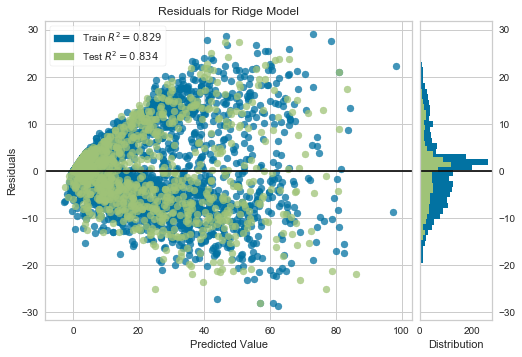

In [137]:
 # Plot the Residuals for Ridge Model
    
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()  

In [138]:
# Display mean squared error and R2 value for linear regression model.

from sklearn.metrics import mean_squared_error

predictions = model.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 70.28476865287318, R2: 0.8342292222262847


# Predictive Model Comparison with Actual Model

In [142]:
# Read in 2006 data only to test our model

advanced = pd.read_csv('test_data/2006_advanced.csv')

player = pd.read_csv('test_data/2006_player.csv')


,Rk,Player,Age,Tm,Pos,GP,CF,CA,CF%,CF% rel,...,PDO,oZS%,dZS%,TOI/60,TOI(EV),TK,GV,E+/-,SAtt.,Thru%
0,1,Justin Abdelkader\abdelju01,30,DET,LW,75,888,910,49.4,0.7,...,98.6,49.8,50.2,16:33,12:49,21,34,-6.4,200.0,54.5
1,2,Pontus Aberg\abergpo01,24,TOT,LW,53,524,610,46.2,-4.0,...,104.1,56.9,43.1,12:10,11:48,12,20,-2.7,125.0,56.0
2,3,Noel Acciari\acciano01,26,BOS,C,60,584,629,48.1,-6.6,...,97.2,32.4,67.6,12:55,11:24,20,9,1.4,113.0,58.4
3,4,Kenny Agostino\agostke01,25,BOS,LW,5,34,48,41.5,-8.5,...,96.8,37.5,62.5,12:03,8:59,1,0,-0.3,17.0,64.7
4,5,Sebastian Aho\ahose01,20,CAR,RW,78,1259,1015,55.4,0.9,...,99.4,57.0,43.0,17:55,15:12,59,53,5.5,390.0,51.3


In [144]:
# Merge the player and advanced dataframes together on player and age.

merged_df = pd.merge(player,
                 advanced,
                 on=['Player', 'Age'], 
                 #how='outer', 
                 indicator=True
                )
merged_df.head()

,Player,Age,Tm_x,Pos_x,GP_x,G,A,PTS,+/-,PIM,...,TK,TOI(EV),TOI/60,Thru%,Tm_y,dZS%,oZS%,oiSH%,oiSV%,_merge
0,Spencer Abbott\abbotsp01,28,CHI,LW,1,0,0,0,0,0,...,1,8:34,8:34,50.0,CHI,0.0,100.0,0.0,100.0,both
1,Justin Abdelkader\abdelju01,29,DET,LW,64,7,14,21,-20,50,...,15,13:07,16:39,65.0,DET,53.7,46.3,5.3,91.1,both
2,Pontus Aberg\abergpo01,23,NSH,LW,15,1,1,2,-2,4,...,5,12:05,12:20,50.0,NSH,51.7,48.3,6.6,92.1,both
3,Noel Acciari\acciano01,25,BOS,C,29,2,3,5,3,16,...,10,10:01,10:14,55.8,BOS,59.1,40.9,7.8,95.8,both
4,Kenny Agostino\agostke01,24,STL,LW,7,1,2,3,0,2,...,1,11:30,12:47,65.4,STL,39.6,60.4,5.8,90.9,both


In [151]:
# Replace NAN values with the mean

merged_df.fillna(cleandf.mean(), inplace=True)

In [152]:
# Prepare data for regression

cleandf = merged_df[['PS', 'CA', 'FA', 'dZS%', 'oZS%']]
cleandf.head()

,PS,CA,FA,dZS%,oZS%
0,0.0,7,6,0.0,100.0
1,0.7,790,593,53.7,46.3
2,-0.1,159,117,51.7,48.3
3,0.5,246,188,59.1,40.9
4,0.3,64,47,39.6,60.4


In [153]:
# Loop through each row in the 2016 data and predict points for each
# Create a dataframe which includes the predicted points, actual points and
# the difference between predicted and actual point.

X = cleandf
y = merged_df['PTS']

for index, row in X.iterrows():
    X_predict = sc.transform(X)
    y_predict = model.predict(X_predict)
    y_predict
    
comparison = pd.DataFrame({'Predicted Scores':y_predict, 'Actual Scores':y})
# comparison.head(5)
comparison['Score Difference'] = y_predict - y


In [158]:
comparison.head(20)

,Predicted Scores,Actual Scores,Score Difference
0,3.689897,0,3.689897
1,10.856286,21,-10.143714
2,2.407059,2,0.407059
3,6.492756,5,1.492756
4,4.573652,3,1.573652
5,44.067459,49,-4.932541
6,36.259745,13,23.259745
7,30.304853,29,1.304853
8,1.885765,0,1.885765
9,1.713241,2,-0.286759


In [154]:
# View .describe() data to create cutoffs for regplot

comparison['Score Difference'].describe()

count    8845.000000
mean       -0.011844
std         8.583963
min       -32.048712
25%        -5.659884
50%         0.434840
75%         3.488849
max        31.253352
Name: Score Difference, dtype: float64

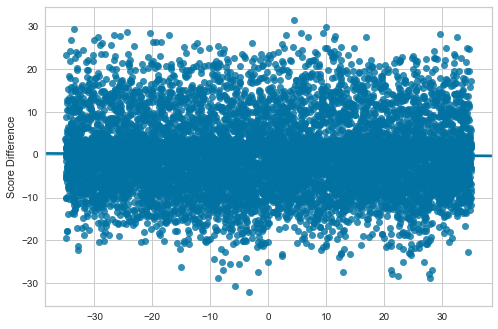

In [156]:
# Plot the point differences on a   regression scatter plot that shows linear regression line
# and 95% confidence interval for the regression line

x = np.linspace(-35, 35, 8845)
y = comparison['Score Difference']

sns.regplot(x,y)


<center><img src="images/miracle.jpg"><center>


# "Do you believe in Miracles?"  


###### All hockey statistcs used in this analysis were downloaded from https://www.hockey-reference.com